In [1]:
# !wget "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


Remark: I have use the following command to install pytorch with cuda 11.8

`conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia`

Get the conda command from the following URL: https://pytorch.org/get-started/locally/ 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch import nn, optim

# Remark: I have use the following command to install pytorch with cuda 11.8
# "conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia"
# https://pytorch.org/get-started/locally/ 

def get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os):
    u_is_c = torch.rand(*list(ds.shape[:2]) + [N_c]).to(ds)
    t_is_c = t_i_c_bin_edges + u_is_c * t_i_c_gap
    r_ts_c = os[..., None, :] + t_is_c[..., :, None] * ds[..., None, :]
    return (r_ts_c, t_is_c)


def render_radiance_volume(r_ts, ds, chunk_size, F, t_is):
    r_ts_flat = r_ts.reshape((-1, 3))
    ds_rep = ds.unsqueeze(2).repeat(1, 1, r_ts.shape[-2], 1)
    ds_flat = ds_rep.reshape((-1, 3))
    c_is = []
    sigma_is = []
    for chunk_start in range(0, r_ts_flat.shape[0], chunk_size):
        r_ts_batch = r_ts_flat[chunk_start : chunk_start + chunk_size]
        ds_batch = ds_flat[chunk_start : chunk_start + chunk_size]
        preds = F(r_ts_batch, ds_batch)
        c_is.append(preds["c_is"])
        sigma_is.append(preds["sigma_is"])

    c_is = torch.cat(c_is).reshape(r_ts.shape)
    sigma_is = torch.cat(sigma_is).reshape(r_ts.shape[:-1])

    delta_is = t_is[..., 1:] - t_is[..., :-1]
    one_e_10 = torch.Tensor([1e10]).expand(delta_is[..., :1].shape)
    delta_is = torch.cat([delta_is, one_e_10.to(delta_is)], dim=-1)
    delta_is = delta_is * ds.norm(dim=-1).unsqueeze(-1)

    alpha_is = 1.0 - torch.exp(-sigma_is * delta_is)

    T_is = torch.cumprod(1.0 - alpha_is + 1e-10, -1)
    T_is = torch.roll(T_is, 1, -1)
    T_is[..., 0] = 1.0

    w_is = T_is * alpha_is

    C_rs = (w_is[..., None] * c_is).sum(dim=-2)

    return C_rs


def run_one_iter_of_tiny_nerf(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c):
    (r_ts_c, t_is_c) = get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os)
    C_rs_c = render_radiance_volume(r_ts_c, ds, chunk_size, F_c, t_is_c)
    return C_rs_c


class VeryTinyNeRFMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.L_pos = 6
        self.L_dir = 4
        pos_enc_feats = 3 + 3 * 2 * self.L_pos
        dir_enc_feats = 3 + 3 * 2 * self.L_dir

        net_width = 256
        self.early_mlp = nn.Sequential(
            nn.Linear(pos_enc_feats, net_width),
            nn.ReLU(),
            nn.Linear(net_width, net_width + 1),
            nn.ReLU(),
        )
        self.late_mlp = nn.Sequential(
            nn.Linear(net_width + dir_enc_feats, net_width),
            nn.ReLU(),
            nn.Linear(net_width, 3),
            nn.Sigmoid(),
        )

    def forward(self, xs, ds):
        xs_encoded = [xs]
        for l_pos in range(self.L_pos):
            xs_encoded.append(torch.sin(2 ** l_pos * torch.pi * xs))
            xs_encoded.append(torch.cos(2 ** l_pos * torch.pi * xs))

        xs_encoded = torch.cat(xs_encoded, dim=-1)

        ds = ds / ds.norm(p=2, dim=-1).unsqueeze(-1)
        ds_encoded = [ds]
        for l_dir in range(self.L_dir):
            ds_encoded.append(torch.sin(2 ** l_dir * torch.pi * ds))
            ds_encoded.append(torch.cos(2 ** l_dir * torch.pi * ds))

        ds_encoded = torch.cat(ds_encoded, dim=-1)

        outputs = self.early_mlp(xs_encoded)
        sigma_is = outputs[:, 0]
        c_is = self.late_mlp(torch.cat([outputs[:, 1:], ds_encoded], dim=-1))
        return {"c_is": c_is, "sigma_is": sigma_is}

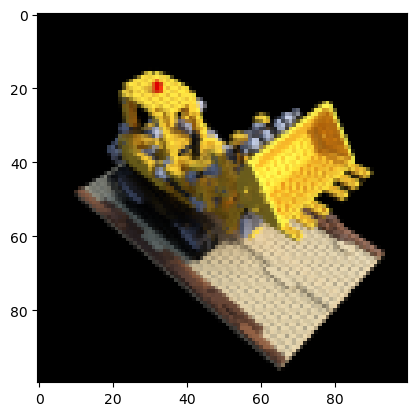

VeryTinyNeRFMLP(
  (early_mlp): Sequential(
    (0): Linear(in_features=39, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=257, bias=True)
    (3): ReLU()
  )
  (late_mlp): Sequential(
    (0): Linear(in_features=283, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

In [2]:
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

device = "cuda:0"
F_c = VeryTinyNeRFMLP().to(device)
chunk_size = 16384

lr = 5e-3
optimizer = optim.Adam(F_c.parameters(), lr=lr)
criterion = nn.MSELoss()

data_f = "tiny_nerf_data.npz"
data = np.load(data_f)

images = data["images"]
img_size = images.shape[1]
xs = torch.arange(img_size) - (img_size / 2 - 0.5)
ys = torch.arange(img_size) - (img_size / 2 - 0.5)
(xs, ys) = torch.meshgrid(xs, -ys, indexing="xy")
focal = float(data["focal"])
pixel_coords = torch.stack([xs, ys, torch.full_like(xs, -focal)], dim=-1)
camera_coords = pixel_coords / focal
init_ds = camera_coords.to(device)
camera_distance = float(np.linalg.norm(data["poses"][0, :3, -1]))
init_o = torch.Tensor(np.array([0, 0, camera_distance])).to(device)

test_idx = 101
plt.imshow(images[test_idx])
plt.show()
test_img = torch.Tensor(images[test_idx]).to(device)
poses = data["poses"]
test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
test_os = (test_R @ init_o).expand(test_ds.shape)

t_n = 2.0
t_f = 6.0
N_c = 64
t_i_c_gap = (t_f - t_n) / N_c
t_i_c_bin_edges = (t_n + torch.arange(N_c) * t_i_c_gap).to(device)

train_idxs = np.arange(len(images)) != test_idx
images = torch.Tensor(images[train_idxs])
poses = torch.Tensor(poses[train_idxs])
psnrs = []
iternums = []
num_iters = 20000
display_every = 100
F_c.train()

In [3]:
!nvidia-smi
torch.cuda.is_available()


Sun Dec  3 00:32:49 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 980 Ti    WDDM  | 00000000:01:00.0  On |                  N/A |
| 24%   56C    P5              31W / 260W |   1355MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

Loss: 0.138972207903862


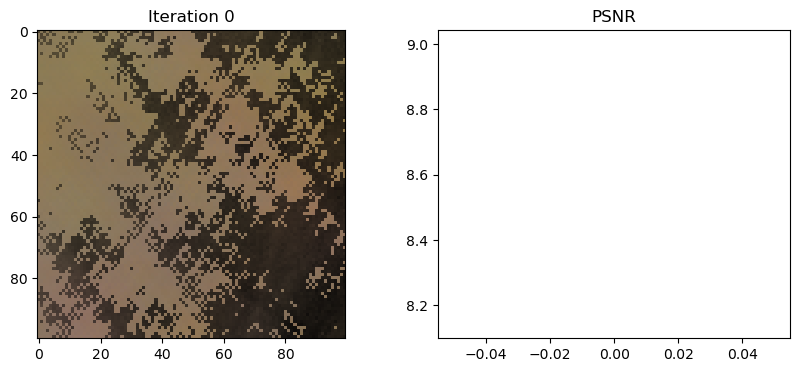

Loss: 0.024803129956126213


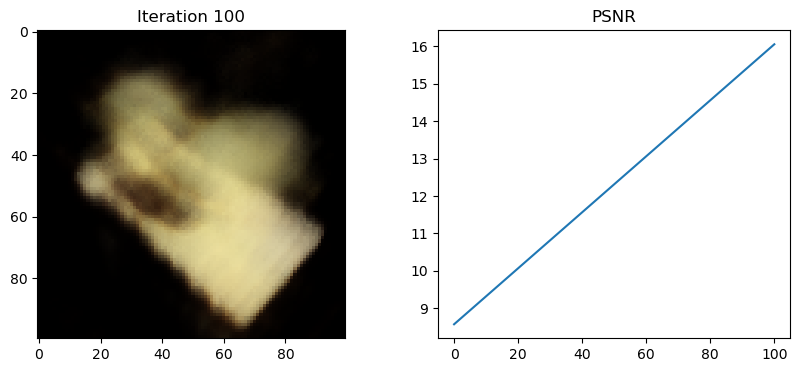

Loss: 0.013520453125238419


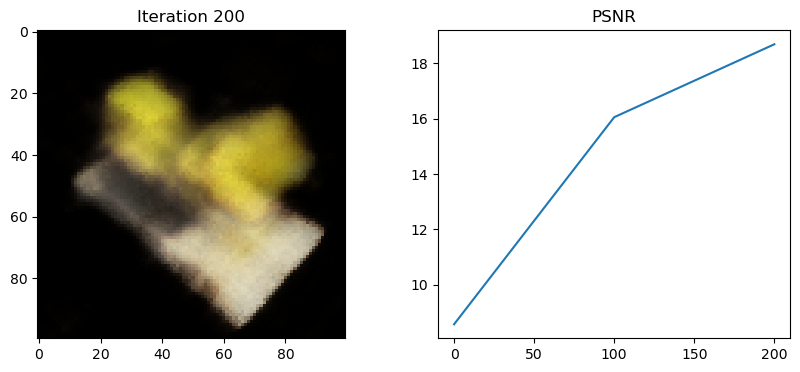

Loss: 0.0114002525806427


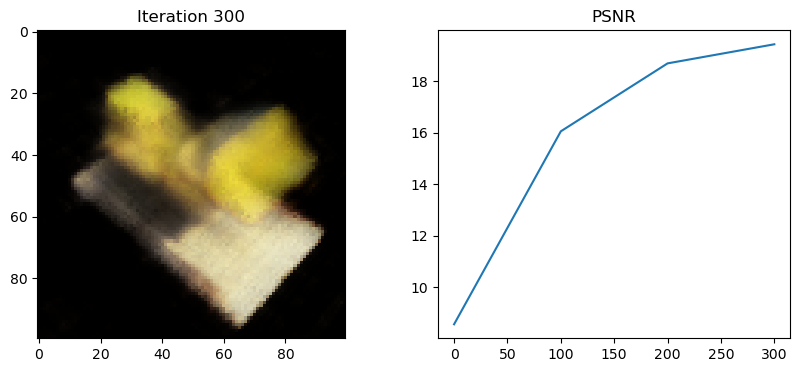

Loss: 0.009897042065858841


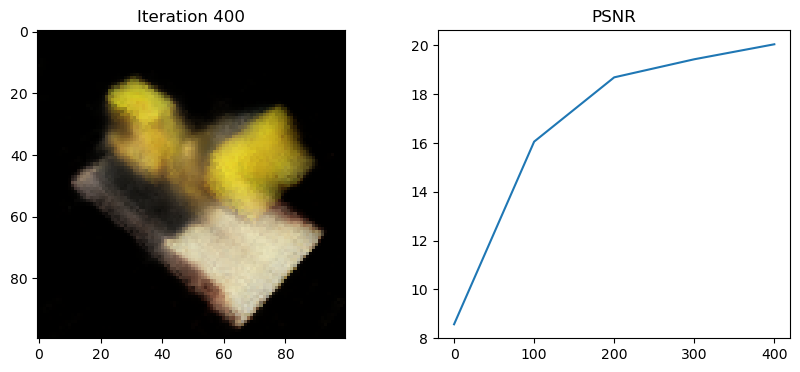

Loss: 0.0084619652479887


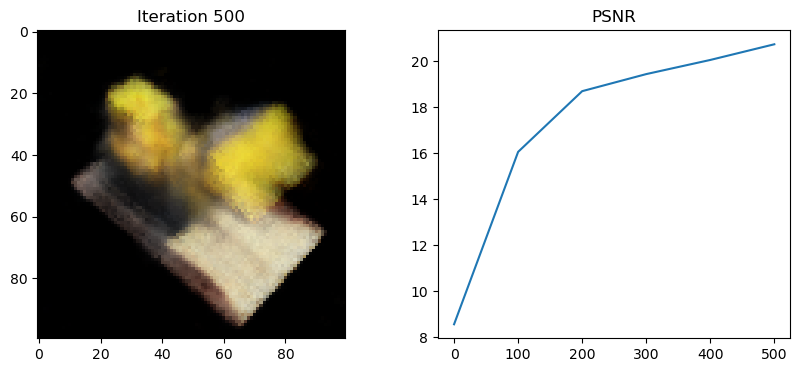

Loss: 0.008991217240691185


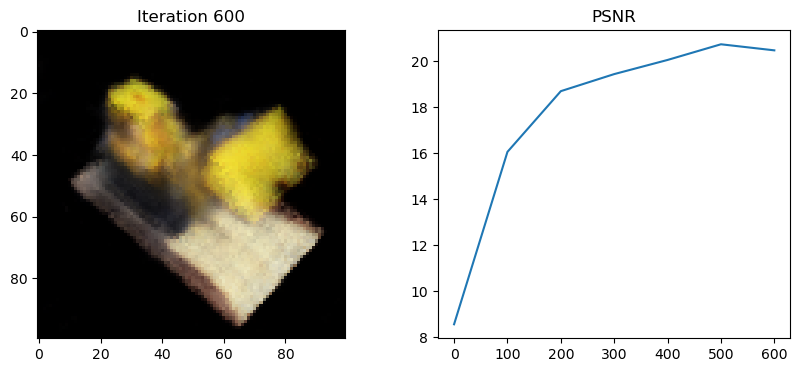

Loss: 0.007541469298303127


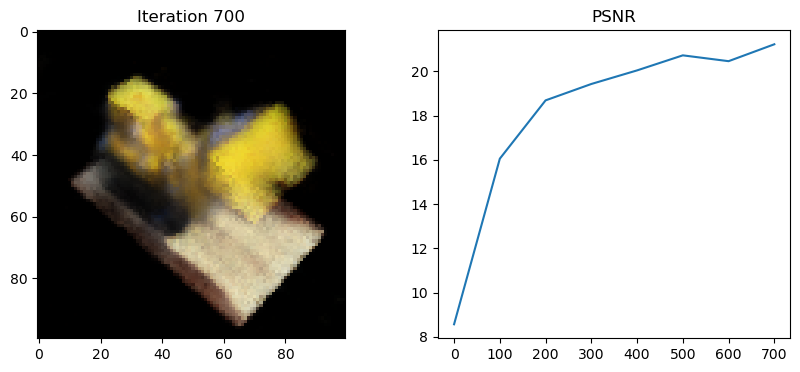

Loss: 0.007049907930195332


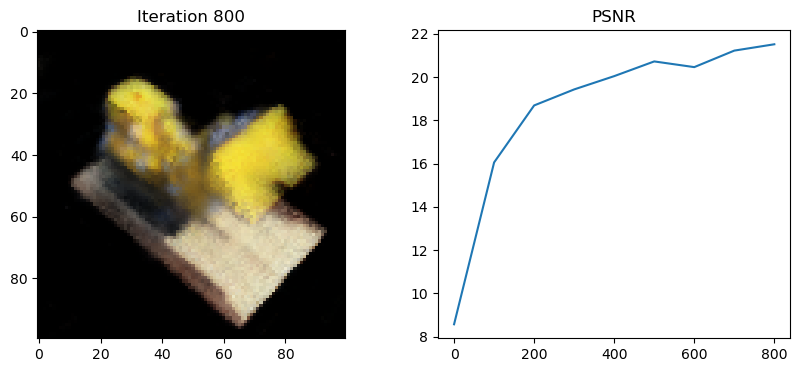

Loss: 0.007435248699039221


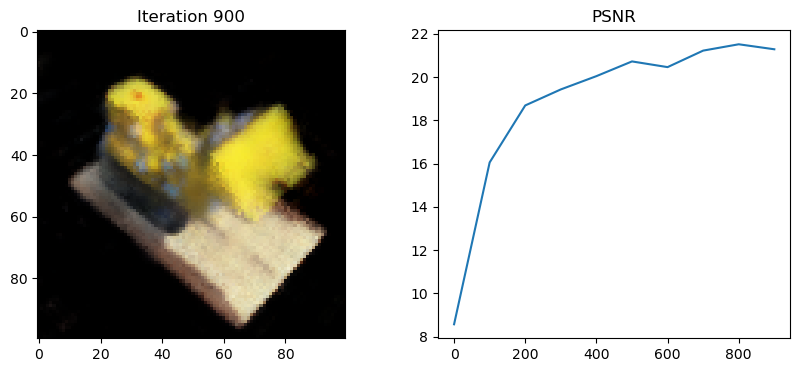

Loss: 0.005990888457745314


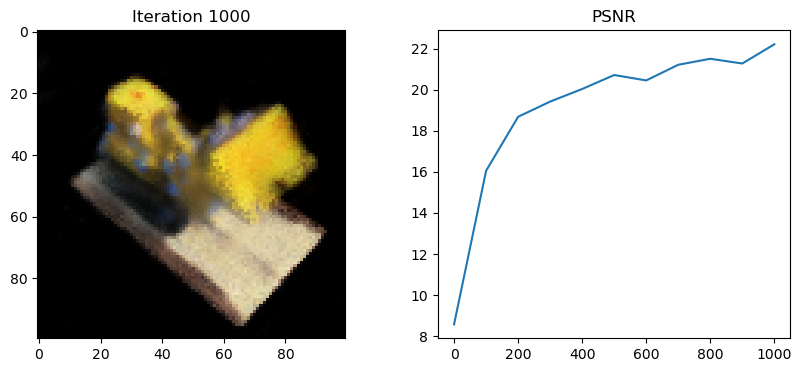

Loss: 0.005824282765388489


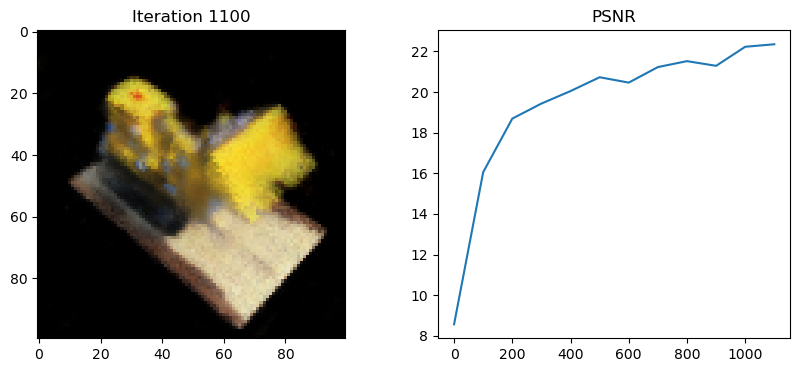

KeyboardInterrupt: 

In [4]:
for i in range(num_iters):
    target_img_idx = np.random.randint(images.shape[0])
    target_pose = poses[target_img_idx].to(device)
    R = target_pose[:3, :3]

    ds = torch.einsum("ij,hwj->hwi", R, init_ds)
    os = (R @ init_o).expand(ds.shape)

    C_rs_c = run_one_iter_of_tiny_nerf(
        ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c
    )
    loss = criterion(C_rs_c, images[target_img_idx].to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % display_every == 0:
        F_c.eval()
        with torch.no_grad():
            C_rs_c = run_one_iter_of_tiny_nerf(
                test_ds, N_c, t_i_c_bin_edges, t_i_c_gap, test_os, chunk_size, F_c
            )

        loss = criterion(C_rs_c, test_img)
        print(f"Loss: {loss.item()}")
        psnr = -10.0 * torch.log10(loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(C_rs_c.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

        F_c.train()

print("Done!")